In [1]:
from vnstock import Vnstock
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Vnstock with REE symbol
stock = Vnstock().stock(symbol='REE', source='VCI')

# Get historical data for REE
# Using a reasonable date range (you can adjust these dates as needed)
ree_hist = stock.quote.history(symbol='REE', 
                               start='2023-01-01', 
                               end='2025-05-26',  # Current date
                               interval='1D')     # Daily data

# Display the first few rows of the data
print("REE Stock Price Data:")
print(ree_hist.head())



Phiên bản Vnstock 3.2.6 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.5

REE Stock Price Data:
        time   open   high    low  close  volume
0 2023-01-03  51.57  53.38  51.57  52.44  276158
1 2023-01-04  53.17  53.17  52.23  52.88  213149
2 2023-01-05  52.59  53.89  52.59  53.89  393921
3 2023-01-06  53.38  53.89  52.80  53.74  153430
4 2023-01-09  53.82  54.11  52.44  53.09  231128


In [2]:
ree_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    593 non-null    datetime64[ns]
 1   open    593 non-null    float64       
 2   high    593 non-null    float64       
 3   low     593 non-null    float64       
 4   close   593 non-null    float64       
 5   volume  593 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 27.9 KB


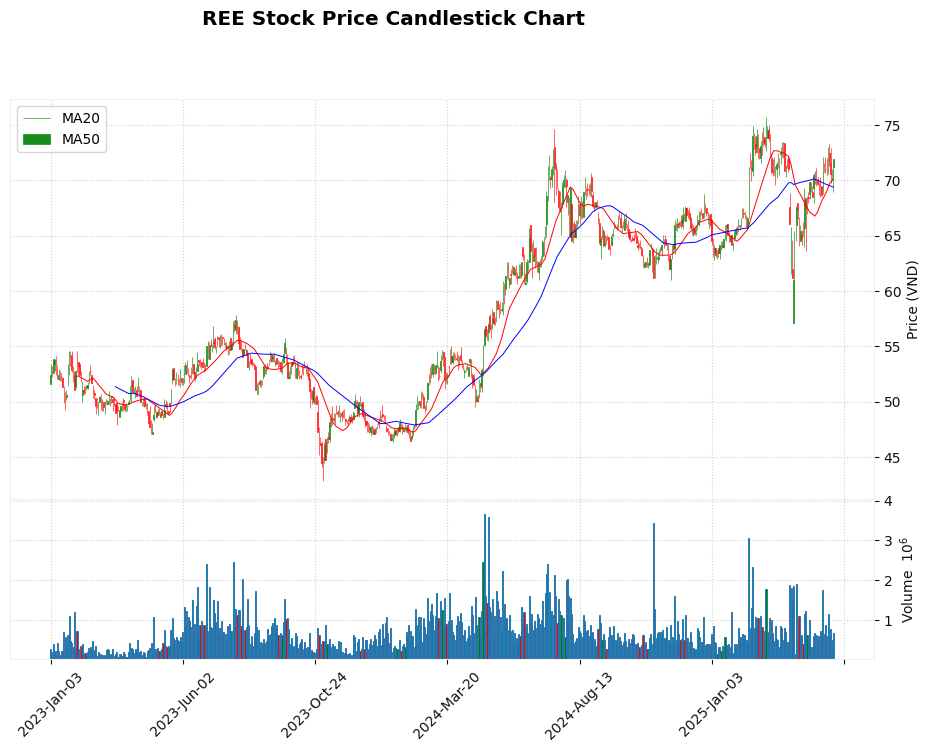

In [3]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt

# mplfinance requires the DataFrame to be indexed by the date/time
# Convert time column to datetime if it's not already
ree_hist['time'] = pd.to_datetime(ree_hist['time'])

# Set the time column as the index
ree_hist = ree_hist.set_index('time')

# Add some technical indicators - Moving Averages
ree_hist['MA20'] = ree_hist['close'].rolling(window=20).mean()
ree_hist['MA50'] = ree_hist['close'].rolling(window=50).mean()

# Create a plot with mplfinance
# Define Moving Average overlays
ma20 = mpf.make_addplot(ree_hist['MA20'], color='red', width=0.7)
ma50 = mpf.make_addplot(ree_hist['MA50'], color='blue', width=0.7)

# Define the chart style
mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, 
                      gridstyle=':', facecolor='white')

# Create the plot
fig, axes = mpf.plot(ree_hist, 
                    type='candle', 
                    style=s,
                    title='REE Stock Price Candlestick Chart',
                    ylabel='Price (VND)',
                    addplot=[ma20, ma50],
                    volume=True,
                    figsize=(12, 8),
                    returnfig=True)

# Add a legend
axes[0].legend(['MA20', 'MA50'])

# Rotate date labels for better readability
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

# Save the figure
#plt.savefig('.outputs/ree_candlestick_chart.png')
plt.show()

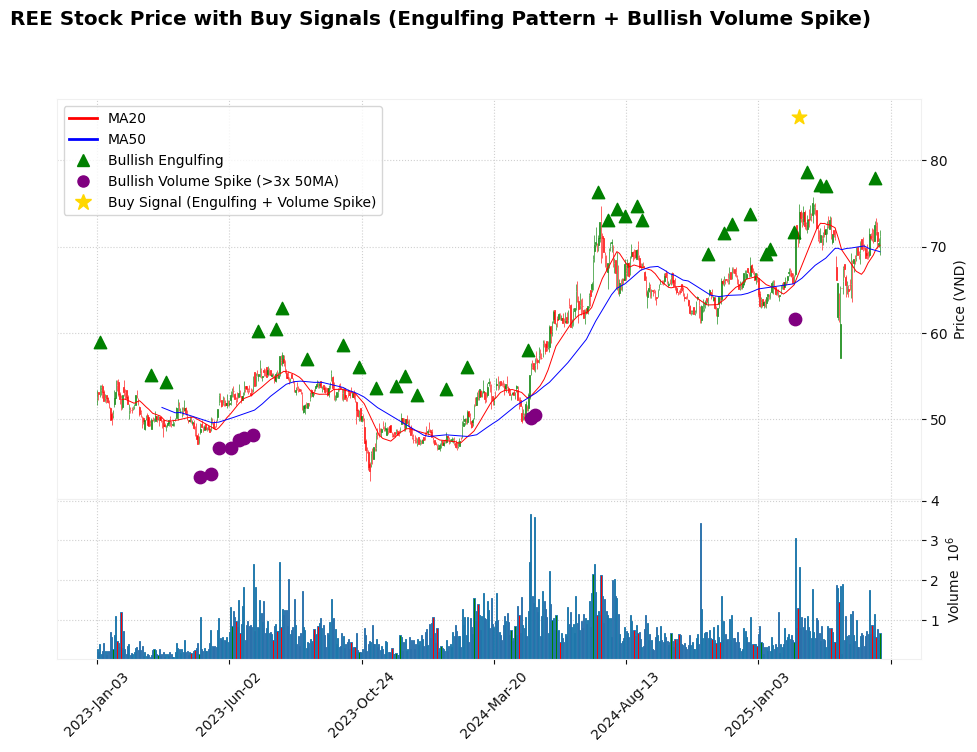

Found 34 bullish engulfing patterns in the dataset.
Found 11 bullish volume spikes (>3x 50-day MA) in the dataset.
Found 1 buy signals (engulfing + volume spike) in the dataset.

Buy Signal Dates (Engulfing + Volume Spike):
- 2025-02-24

Buy Signal Success Rate: 100.00% resulted in higher prices within 5 candles
Regular Engulfing Success Rate (without volume spike): 90.91%
Improvement with volume spike: 9.09%


In [9]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import talib

# Make a copy of the DataFrame to avoid modifying the original
df = ree_hist.copy()

# Identify bullish engulfing patterns
df['bullish_engulfing'] = talib.CDLENGULFING(df['open'].values, df['high'].values, 
                                            df['low'].values, df['close'].values) > 0

# NEW VOLUME SPIKE DEFINITION:
# 1. Calculate 50-day moving average of volume
df['volume_ma50'] = df['volume'].rolling(window=50).mean()

# 2. Identify bullish candles
df['is_bullish'] = df['close'] > df['open']

# 3. Calculate volume ratio and identify significant volume spikes (3x the 50-day MA)
df['volume_ratio'] = df['volume'] / df['volume_ma50']
df['volume_spike'] = (df['volume_ratio'] > 3.0) & df['is_bullish']

# Define buy signal: bullish engulfing pattern + bullish volume spike
df['buy_signal'] = df['bullish_engulfing'] & df['volume_spike']

# Create marker columns with NaN values where no pattern exists
df['marker_bullish'] = np.nan  # Just engulfing pattern
df['marker_volume_spike'] = np.nan  # Just volume spike
df['marker_buy_signal'] = np.nan  # Engulfing + volume spike

# Set marker values only where patterns occur
df.loc[df['bullish_engulfing'] & ~df['volume_spike'], 'marker_bullish'] = df.loc[df['bullish_engulfing'] & ~df['volume_spike'], 'high'] + 5
df.loc[df['volume_spike'] & ~df['bullish_engulfing'], 'marker_volume_spike'] = df.loc[df['volume_spike'] & ~df['bullish_engulfing'], 'low'] - 5
df.loc[df['buy_signal'], 'marker_buy_signal'] = df.loc[df['buy_signal'], 'high'] + 10

# Create the plot with mplfinance
# First define moving average overlays
ma20 = mpf.make_addplot(df['MA20'], color='red', width=0.7)
ma50 = mpf.make_addplot(df['MA50'], color='blue', width=0.7)

# Add the pattern markers
bullish_engulfing_plot = mpf.make_addplot(df['marker_bullish'], type='scatter', 
                                         markersize=80, marker='^', color='green')
volume_spike_plot = mpf.make_addplot(df['marker_volume_spike'], type='scatter',
                                   markersize=80, marker='o', color='purple')
buy_signal_plot = mpf.make_addplot(df['marker_buy_signal'], type='scatter', 
                                  markersize=120, marker='*', color='gold')

# Combine all plots
plots = [ma20, ma50, bullish_engulfing_plot, volume_spike_plot, buy_signal_plot]

# Define the chart style
mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, 
                      gridstyle=':', facecolor='white')

# Create the plot
fig, axes = mpf.plot(df, 
                    type='candle', 
                    style=s,
                    title='REE Stock Price with Buy Signals (Engulfing Pattern + Bullish Volume Spike)',
                    ylabel='Price (VND)',
                    addplot=plots,
                    volume=True,
                    figsize=(12, 8),
                    returnfig=True)

# Add a custom legend
handles = [
    plt.Line2D([0], [0], color='red', linewidth=2, label='MA20'),
    plt.Line2D([0], [0], color='blue', linewidth=2, label='MA50'),
    plt.Line2D([0], [0], marker='^', color='green', linestyle='None', 
              markersize=8, label='Bullish Engulfing'),
    plt.Line2D([0], [0], marker='o', color='purple', linestyle='None',
              markersize=8, label='Bullish Volume Spike (>3x 50MA)'),
    plt.Line2D([0], [0], marker='*', color='gold', linestyle='None', 
              markersize=12, label='Buy Signal (Engulfing + Volume Spike)')
]
axes[0].legend(handles=handles, loc='upper left')

# Rotate date labels for better readability
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

plt.show()

# Print statistics about the patterns and signals
pattern_count = df['bullish_engulfing'].sum()
volume_spike_count = df['volume_spike'].sum()
signal_count = df['buy_signal'].sum()

print(f"Found {pattern_count} bullish engulfing patterns in the dataset.")
print(f"Found {volume_spike_count} bullish volume spikes (>3x 50-day MA) in the dataset.")
print(f"Found {signal_count} buy signals (engulfing + volume spike) in the dataset.")

if signal_count > 0:
    # Show dates of the buy signals
    signal_dates = df[df['buy_signal']].index
    print("\nBuy Signal Dates (Engulfing + Volume Spike):")
    for date in signal_dates:
        print(f"- {date.date()}")
    
    # Calculate success rate for buy signals
    success_count = 0
    for idx in df[df['buy_signal']].index:
        try:
            # Get position of the current index
            pos = df.index.get_loc(idx)
            # Check if there are at least 5 more candles after this one
            if pos + 5 < len(df):
                # Success means price went higher within next 5 candles
                if df.iloc[pos+1:pos+6]['high'].max() > df.loc[idx, 'close']:
                    success_count += 1
        except:
            pass
    
    if signal_count > 0:
        success_rate = (success_count / signal_count) * 100
        print(f"\nBuy Signal Success Rate: {success_rate:.2f}% resulted in higher prices within 5 candles")
        
        # Compare with regular engulfing patterns without volume spike
        if pattern_count > signal_count:
            regular_success_count = 0
            for idx in df[(df['bullish_engulfing']) & (~df['buy_signal'])].index:
                try:
                    pos = df.index.get_loc(idx)
                    if pos + 5 < len(df):
                        if df.iloc[pos+1:pos+6]['high'].max() > df.loc[idx, 'close']:
                            regular_success_count += 1
                except:
                    pass
            
            regular_pattern_count = pattern_count - signal_count
            if regular_pattern_count > 0:
                regular_success_rate = (regular_success_count / regular_pattern_count) * 100
                print(f"Regular Engulfing Success Rate (without volume spike): {regular_success_rate:.2f}%")
                print(f"Improvement with volume spike: {success_rate - regular_success_rate:.2f}%")